In [1]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape,RepeatVector
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout,MaxPooling1D,AveragePooling1D,Flatten,Bidirectional


import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.data_split import split_sequence_parallel

# 不加这几句，则CONV 报错
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


In [2]:
data = pd.read_csv("./data/data_1009.csv", header=0,infer_datetime_format=True, engine='python')
data['Unnamed: 0']=pd.to_datetime(data['Unnamed: 0'])
data.set_index("Unnamed: 0",inplace=True)

In [3]:
'''
归一化
'''
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler3 = MinMaxScaler(feature_range=(0, 1))
scaler4 = MinMaxScaler(feature_range=(0, 1))
scaler5 = MinMaxScaler(feature_range=(0, 1))
scaler6 = MinMaxScaler(feature_range=(0, 1))
scaler7 = MinMaxScaler(feature_range=(0, 1))
scaler8 = MinMaxScaler(feature_range=(0, 1))
data_minmax = data.copy()
data_minmax['pm2.5']=scaler1.fit_transform(data_minmax['pm2.5'].values.reshape(-1,1))
data_minmax['DEWP']=scaler2.fit_transform(data_minmax['DEWP'].values.reshape(-1,1))
data_minmax['TEMP']=scaler3.fit_transform(data_minmax['TEMP'].values.reshape(-1,1))
data_minmax['PRES']=scaler4.fit_transform(data_minmax['PRES'].values.reshape(-1,1))
data_minmax['cbwd_NE']=scaler5.fit_transform(data_minmax['cbwd_NE'].values.reshape(-1,1))
data_minmax['cbwd_NW']=scaler6.fit_transform(data_minmax['cbwd_NW'].values.reshape(-1,1))
data_minmax['cbwd_SE']=scaler7.fit_transform(data_minmax['cbwd_SE'].values.reshape(-1,1))
data_minmax['cbwd_cv']=scaler7.fit_transform(data_minmax['cbwd_cv'].values.reshape(-1,1))

In [4]:
'''
取一年的时间，10个月做训练和验证，2个月做测试
'''
cast1 = 35064
cast2 = -1464
data_train = data_minmax[cast1:cast2]
data_test = data_minmax[cast2:] 
data_train.shape,data_test.shape

((7296, 8), (1464, 8))

In [5]:
data_train = np.array(data_train)
data_test = np.array(data_test)
data_train.shape,data_test.shape

((7296, 8), (1464, 8))

In [6]:
sw_width = 21
pred_length = 12
verbose_set = 2
X, y, features = split_sequence_parallel(data_train,sw_width,pred_length)
test_x,test_y,test_features = split_sequence_parallel(data_test,sw_width,pred_length)

In [7]:
X.shape,y.shape,data_test.shape

((7264, 21, 8), (7264, 12), (1464, 8))

In [8]:
test_x,test_y,test_features = split_sequence_parallel(data_test,sw_width,pred_length)
test_x.shape,test_y.shape

((1432, 21, 8), (1432, 12))

In [9]:
def Daqff():
    ip = Input(shape=(sw_width,features))
    
    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(ip)    
    y = Activation('relu')(y)
#     y = MaxPooling1D(pool_size=2)(y)
#     y = Dropout(0.3)(y)

    y = Conv1D(256, 3,padding='same',kernel_initializer='he_uniform')(y)
#     y = Dropout(0.3)(y)
    y = Activation('relu')(y)
#     y = Dropout(0.3)(y)

    y = Conv1D(256, 3,padding='same',kernel_initializer='he_uniform')(y)
    y = Activation('relu')(y)
#     y = Dropout(0.3)(y)
     
    y = Bidirectional(LSTM(64,activation="relu"))(y)
#     y = LSTM(64,activation="relu")(y)
#     y = Dropout(0.3)(y)
    y = Dense(64,activation="relu")(y)
    y = Dropout(0.3)(y)
    y = Dense(pred_length)(y)
    model = Model(ip, y)
    model.summary()


    return model

In [10]:
Daqff1 = Daqff()
Daqff1

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 21, 256)           10496     
_________________________________________________________________
activation_1 (Activation)    (None, 21, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 21, 256)           196864    
_________________________________________________________________
activation_2 (Activation)    (None, 21, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 21, 256)           196864    
_________________________________________________________________
activation_3 (Activation)    (None, 21, 256)           0   

In [11]:
import time
from keras import backend as K
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# lr_scheduler = LearningRateScheduler(lr_schedule)
# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)

filepath = "D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\\12hourweights\DAQFF1_weights_best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)
callbacks_list = [checkpoint]

In [12]:
starttime=time.time()
Daqff1.compile(loss=root_mean_squared_error, optimizer='adam')
history1 = Daqff1.fit(X,y,validation_split=0.25,epochs=80, batch_size=32,callbacks=callbacks_list, verbose=2)
endtime=time.time()
dtime=endtime-starttime
print("程序运行时间为：%.8s s" % dtime)  #时间显示到微秒

Train on 5448 samples, validate on 1816 samples
Epoch 1/80
 - 37s - loss: 0.0807 - val_loss: 0.0693

Epoch 00001: val_loss improved from inf to 0.06931, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\12hourweights\DAQFF1_weights_best.hdf5
Epoch 2/80
 - 17s - loss: 0.0635 - val_loss: 0.0475

Epoch 00002: val_loss improved from 0.06931 to 0.04755, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\12hourweights\DAQFF1_weights_best.hdf5
Epoch 3/80
 - 17s - loss: 0.0592 - val_loss: 0.0520

Epoch 00003: val_loss did not improve from 0.04755
Epoch 4/80
 - 16s - loss: 0.0569 - val_loss: 0.0532

Epoch 00004: val_loss did not improve from 0.04755
Epoch 5/80
 - 16s - loss: 0.0556 - val_loss: 0.0442

Epoch 00005: val_loss improved from 0.04755 to 0.04419, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\12hourweights\DAQFF1_weights_best.hdf5
Epoch 6/80
 - 19s - loss: 0.0546 - val_loss: 0.0496

Epoch 00006: val_loss did not improve from 0.04419
Epoch 7/80
 - 16s - loss: 0.0538 - val_loss: 0.0474

Epoch 


Epoch 00075: val_loss did not improve from 0.04371
Epoch 76/80
 - 14s - loss: 0.0294 - val_loss: 0.0540

Epoch 00076: val_loss did not improve from 0.04371
Epoch 77/80
 - 15s - loss: 0.0296 - val_loss: 0.0533

Epoch 00077: val_loss did not improve from 0.04371
Epoch 78/80
 - 14s - loss: 0.0300 - val_loss: 0.0524

Epoch 00078: val_loss did not improve from 0.04371
Epoch 79/80
 - 15s - loss: 0.0294 - val_loss: 0.0535

Epoch 00079: val_loss did not improve from 0.04371
Epoch 80/80
 - 15s - loss: 0.0294 - val_loss: 0.0537

Epoch 00080: val_loss did not improve from 0.04371
程序运行时间为：1173.694 s


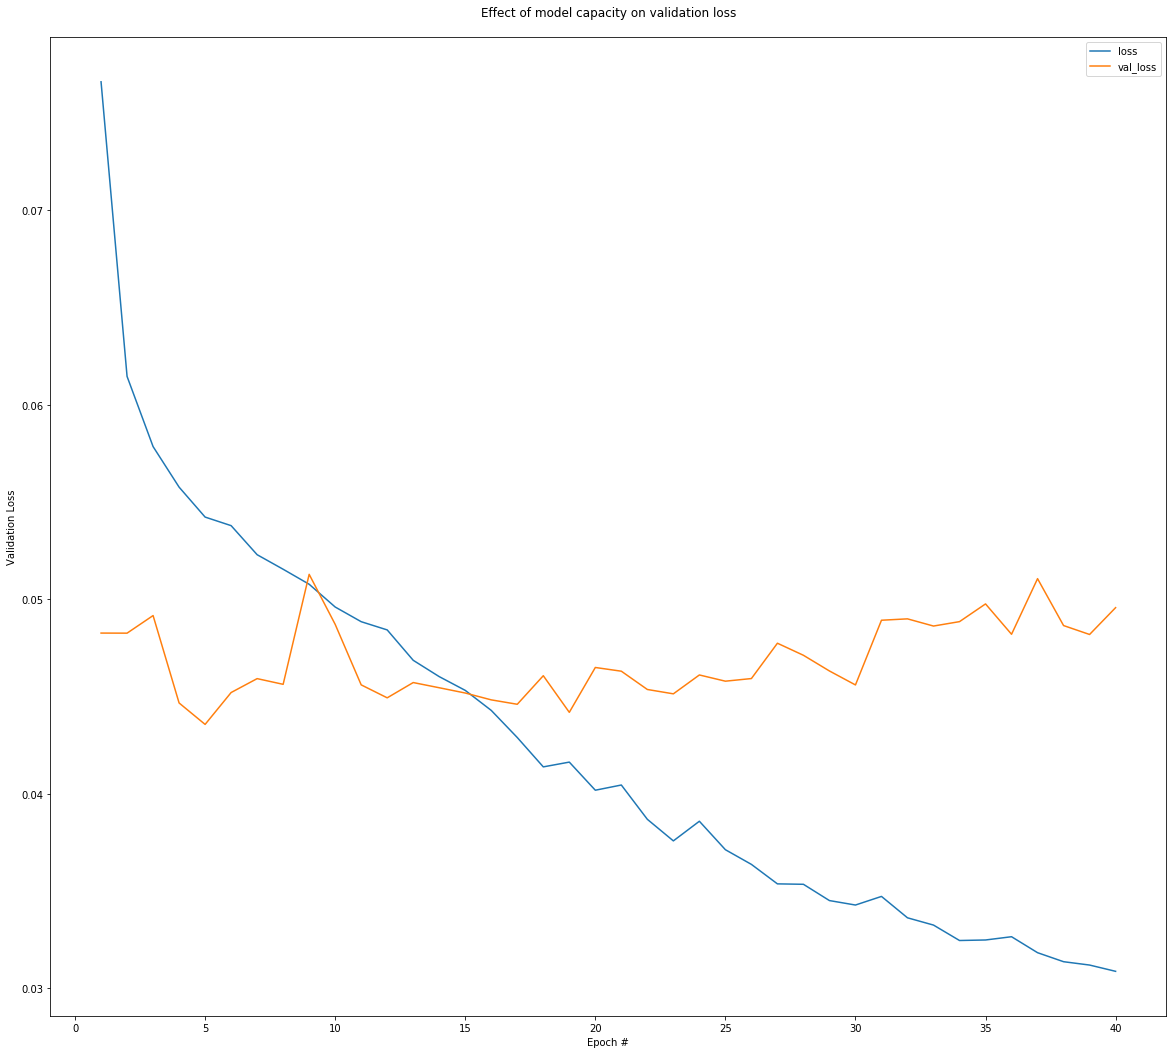

In [65]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = np.arange(40) + 1
plt.figure(figsize=(20,18))
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title("Effect of model capacity on validation loss\n")
plt.xlabel('Epoch #')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

In [11]:
filepath = "D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\\12hourweights\DAQFF_weights_best.hdf5"
Daqff1.load_weights(filepath)

In [12]:
predict=Daqff1.predict(test_x)
predict=scaler1.inverse_transform(predict.reshape(predict.shape[0],predict.shape[1]))

In [13]:
predict.shape,test_y.shape

((1432, 12), (1432, 12))

In [14]:
tf.sqrt(tf.losses.mean_squared_error(predict,scaler1.inverse_transform(test_y))).numpy().mean()

54.00211480558107

In [11]:
filepath = "D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\\12hourweights\DAQFF_weights_best.hdf5"
Daqff1.load_weights(filepath)

In [12]:
predict=Daqff1.predict(test_x)
predict=scaler1.inverse_transform(predict.reshape(predict.shape[0],predict.shape[1]))

In [13]:
tf.losses.mae(predict,scaler1.inverse_transform(test_y)).numpy().mean()

47.674777589710615

In [14]:
print(tf.sqrt(tf.losses.mean_squared_error(predict[:,:6],scaler1.inverse_transform(test_y)[:,:6])).numpy().mean())
print(tf.losses.mae(predict[:,:6],scaler1.inverse_transform(test_y)[:,:6]).numpy().mean())
print(tf.sqrt(tf.losses.mean_squared_error(predict[:,6:],scaler1.inverse_transform(test_y)[:,6:])).numpy().mean())
print(tf.losses.mae(predict[:,6:],scaler1.inverse_transform(test_y)[:,6:]).numpy().mean())

40.49871446823459
36.5149457603693
62.1307312445623
58.83460941905193


In [15]:
for i in range(7):
    loss1 = tf.sqrt(tf.losses.mean_squared_error(predict[:,i],scaler1.inverse_transform(test_y)[:,i])).numpy()
    print(i,":",loss1)

0 : 33.400813264609255
1 : 44.77243675082952
2 : 52.994889889821685
3 : 59.97604302340317
4 : 66.51224376249351
5 : 71.42811969677686
6 : 75.5755848338065


In [16]:
for i in range(7):
    loss1 = tf.sqrt(tf.losses.mae(predict[:,i],scaler1.inverse_transform(test_y)[:,i])).numpy()
    print(i,":",loss1)

0 : 4.908013264809964
1 : 5.51543708955817
2 : 5.877250570484225
3 : 6.196692768327176
4 : 6.5957299468141475
5 : 6.9380332228373565
6 : 7.209215805402212


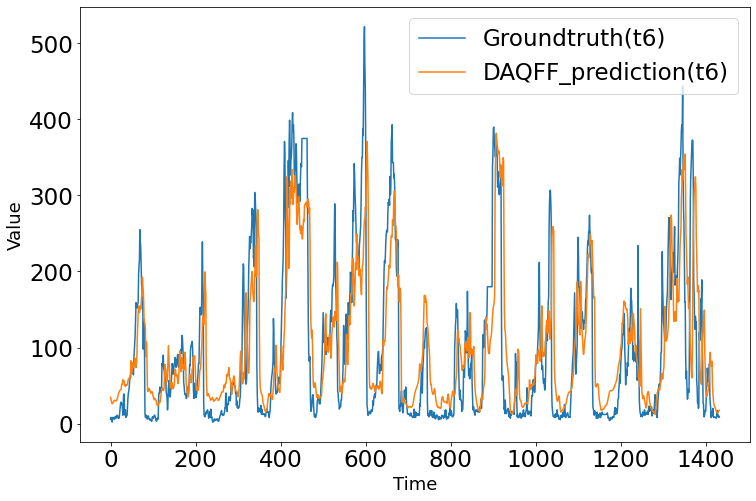

In [18]:
plt.figure(figsize=(12,8))
plt.plot(scaler1.inverse_transform(test_y)[:,5],label='Groundtruth(t6)')
plt.plot(predict[:,5],label='DAQFF_prediction(t6)')
plt.xlabel('test dataset(11/01/2014-12/31/2014)')
plt.ylabel('PM2.5 value')
plt.ylabel('Value',fontsize=18)
plt.xlabel('Time',fontsize=18)
plt.legend(loc="upper right",fontsize=23)
plt.tick_params(labelsize=23)
plt.show()

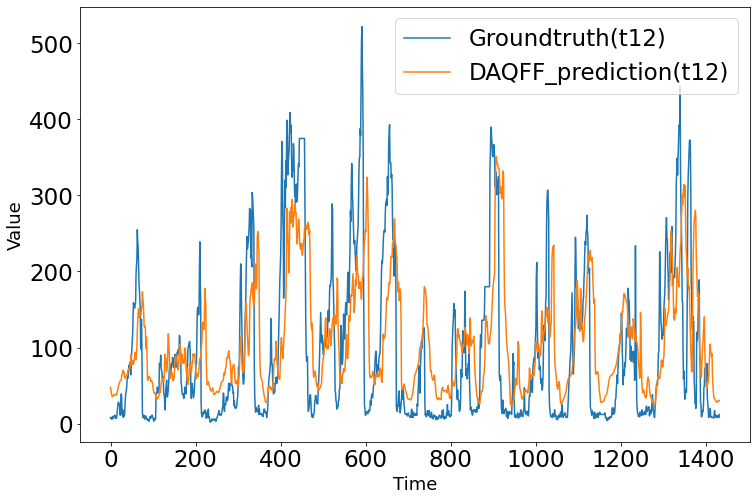

In [19]:
plt.figure(figsize=(12,8))
plt.plot(scaler1.inverse_transform(test_y)[:,11],label='Groundtruth(t12)')
plt.plot(predict[:,11],label='DAQFF_prediction(t12)')
plt.xlabel('test dataset(11/01/2014-12/31/2014)')
plt.ylabel('PM2.5 value')
plt.ylabel('Value',fontsize=18)
plt.xlabel('Time',fontsize=18)
plt.legend(loc="upper right",fontsize=23)
plt.tick_params(labelsize=23)
plt.show()